# AllLife Credit Card Customer Segmentation

In [1]:
# import necessary libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import plotly_express as px
from sklearn.cluster import KMeans


from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

sns.set()

In [2]:
# Read file and load into dataframe
credit_df = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
# basic dataframe inspecting
credit_df.shape

(660, 7)

In [4]:
# credit card info
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [5]:
# check dataframe head
credit_df.head()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
1                  0                   10                 9  
2                  1                    3                 4  
3                  1                    1                 4  
4                  0                   12                 3

### By looking at dataframe,  all columns are numeric, there is no categorical column.

In [6]:
# check for empty or None value
credit_df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [7]:
credit_df.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

### Data has no empty or None value that need to be filled or replaced

In [8]:
# Check data numerical five point value for data range.
credit_df.describe().transpose()


count          mean           std      min       25%  \
Sl_No                660.0    330.500000    190.669872      1.0    165.75   
Customer Key         660.0  55141.443939  25627.772200  11265.0  33825.25   
Avg_Credit_Limit     660.0  34574.242424  37625.487804   3000.0  10000.00   
Total_Credit_Cards   660.0      4.706061      2.167835      1.0      3.00   
Total_visits_bank    660.0      2.403030      1.631813      0.0      1.00   
Total_visits_online  660.0      2.606061      2.935724      0.0      1.00   
Total_calls_made     660.0      3.583333      2.865317      0.0      1.00   

                         50%       75%       max  
Sl_No                  330.5    495.25     660.0  
Customer Key         53874.5  77202.50   99843.0  
Avg_Credit_Limit     18000.0  48000.00  200000.0  
Total_Credit_Cards       5.0      6.00      10.0  
Total_visits_bank        2.0      4.00       5.0  
Total_visits_online      2.0      4.00      15.0  
Total_calls_made         3.0      5.00      10.0

### By observing data, Sl_no is just a sequence number and Customer Key is a unique id , so there will not be any clustering accounting measure for these two fields. Data may contain some outliers that we can take care.

In [9]:
# For EDA, Define necessary functions.
def plot_variable_colums(category,horizontal=3, verticle=2):
    figure, ax = plt.subplots(horizontal, verticle, figsize=(20, 20))
    for var, subplot in zip(category, ax.flatten()):
        sns.distplot(credit_df[var], ax=subplot,bins=10, color="darkblue",kde=True)
def plot_box_plots_for_numeric_variable(category,horizontal=4, verticle=2):
    figure, ax = plt.subplots(horizontal, verticle, figsize=(20, 20))
    for var, subplot in zip(category, ax.flatten()):
        #x="day", y="total_bill", data=tips)
        sns.boxplot(x=var, data=credit_df, ax=subplot)

In [10]:
features=["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]

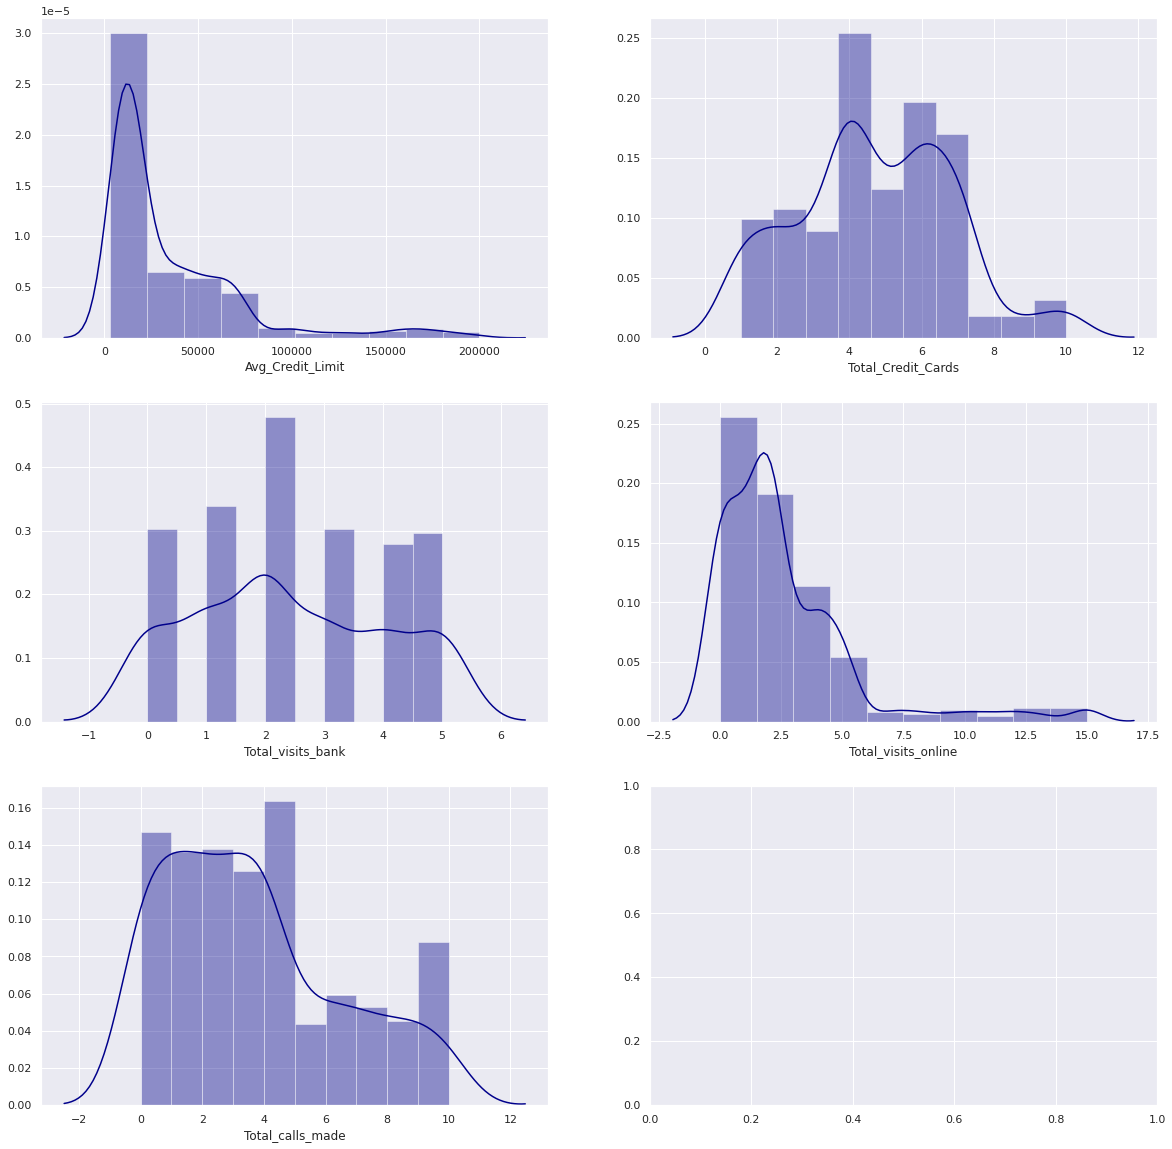

In [11]:
# data frequnecy distribution.
plot_variable_colums(features,horizontal=3,verticle=2)

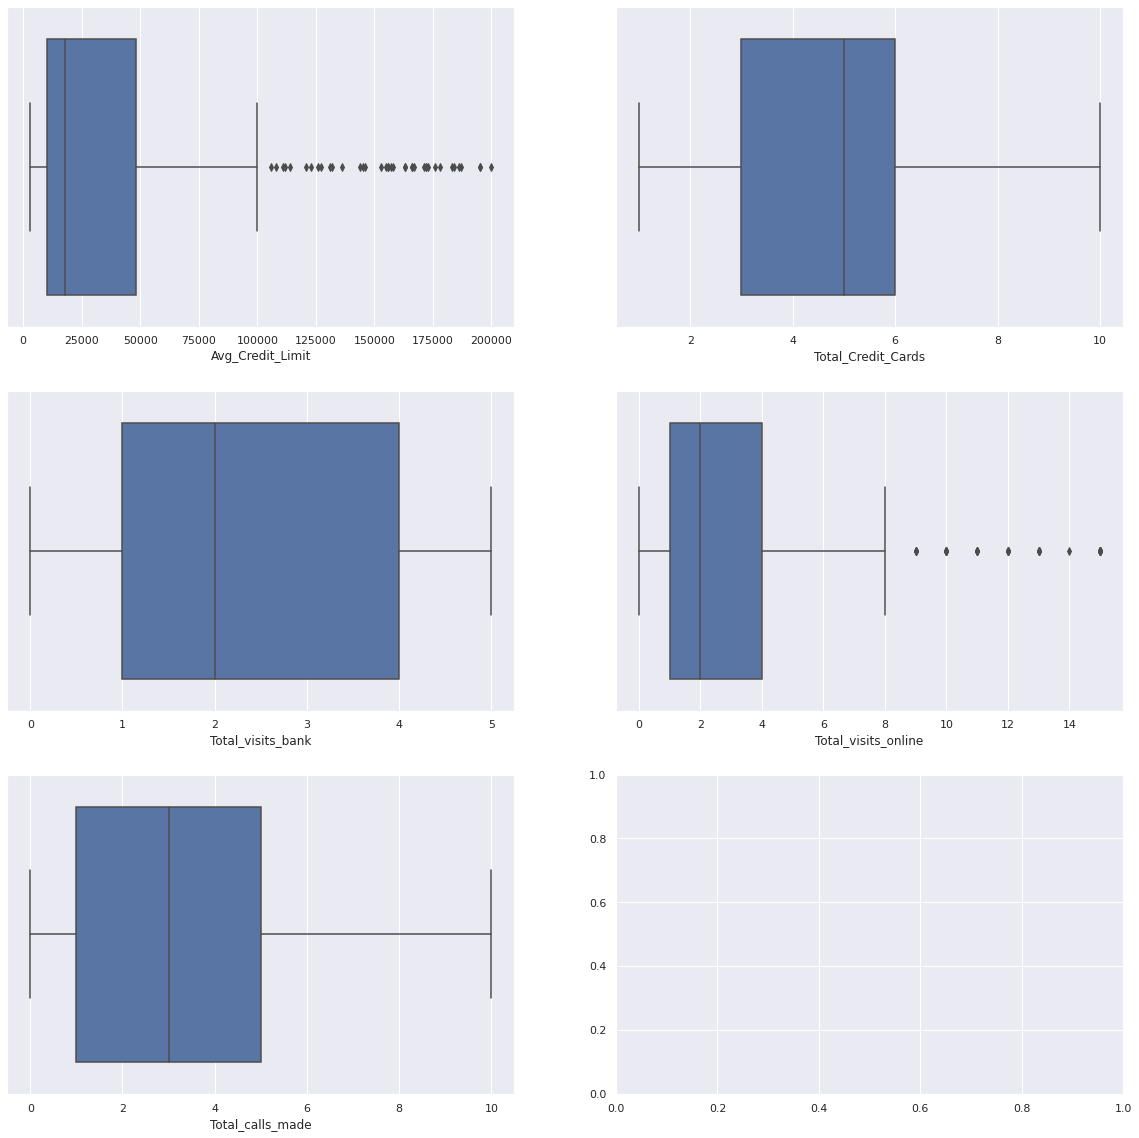

In [12]:
plot_box_plots_for_numeric_variable(features,horizontal=3,verticle=2)

### By looking at box plot, concluding that there are some outliers in main two cloumns 1) Avg_Credit_Limit 2) Total_visits_online.

In [13]:
# Checking for outliers
Q1 = credit_df.quantile(0.25)
Q3 = credit_df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((credit_df.iloc[:] < (Q1 - 1.5*IQR))|(credit_df.iloc[:]>(Q3 +1.5*IQR))).sum(axis=0)
outliers_df = pd.DataFrame(outliers,index=credit_df.columns,columns=['Total Outliers'])
outliers_df

Total Outliers
Sl_No                             0
Customer Key                      0
Avg_Credit_Limit                 39
Total_Credit_Cards                0
Total_visits_bank                 0
Total_visits_online              37
Total_calls_made                  0

### Since these outliers on two fields only and not much in number, we can simply keep them for now , alternet approch we can replace with imputer. but here we can keep it.

In [14]:
# Since Customer Key and Sl_No both columns are just customer idetiifiers, both fileds will not be accountable for 
# clustering 
compute_df = credit_df.drop(['Customer Key','Sl_No'],axis=1)

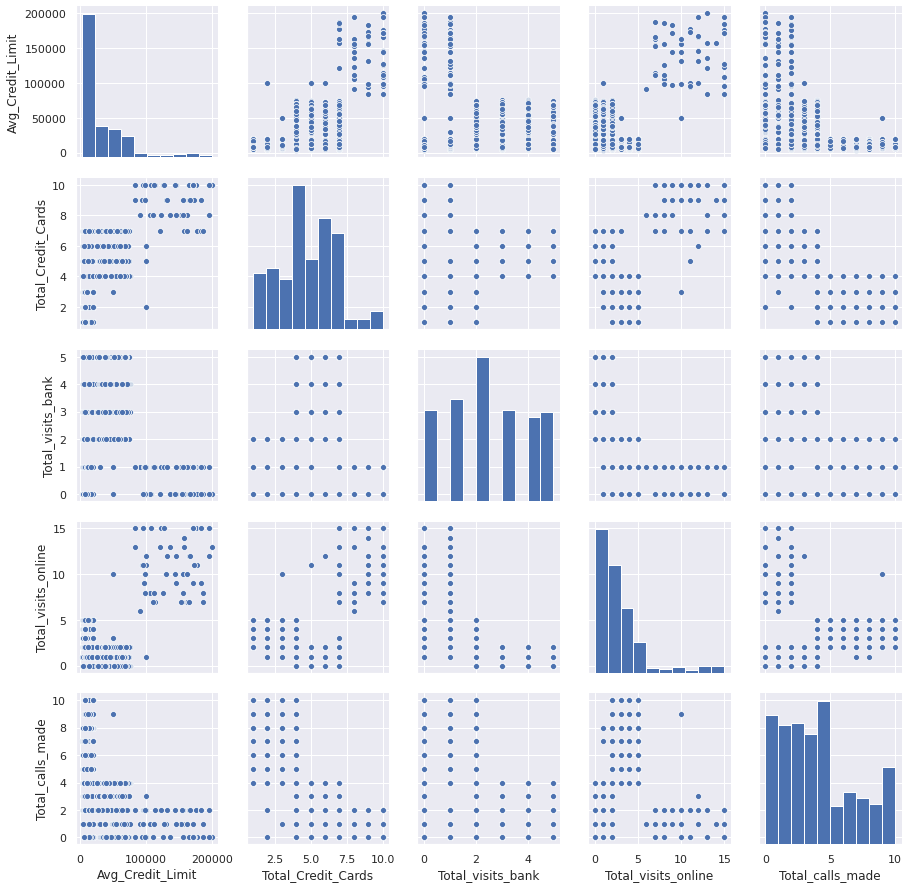

In [15]:
# Bi Variant pair plot
sns.pairplot(compute_df);

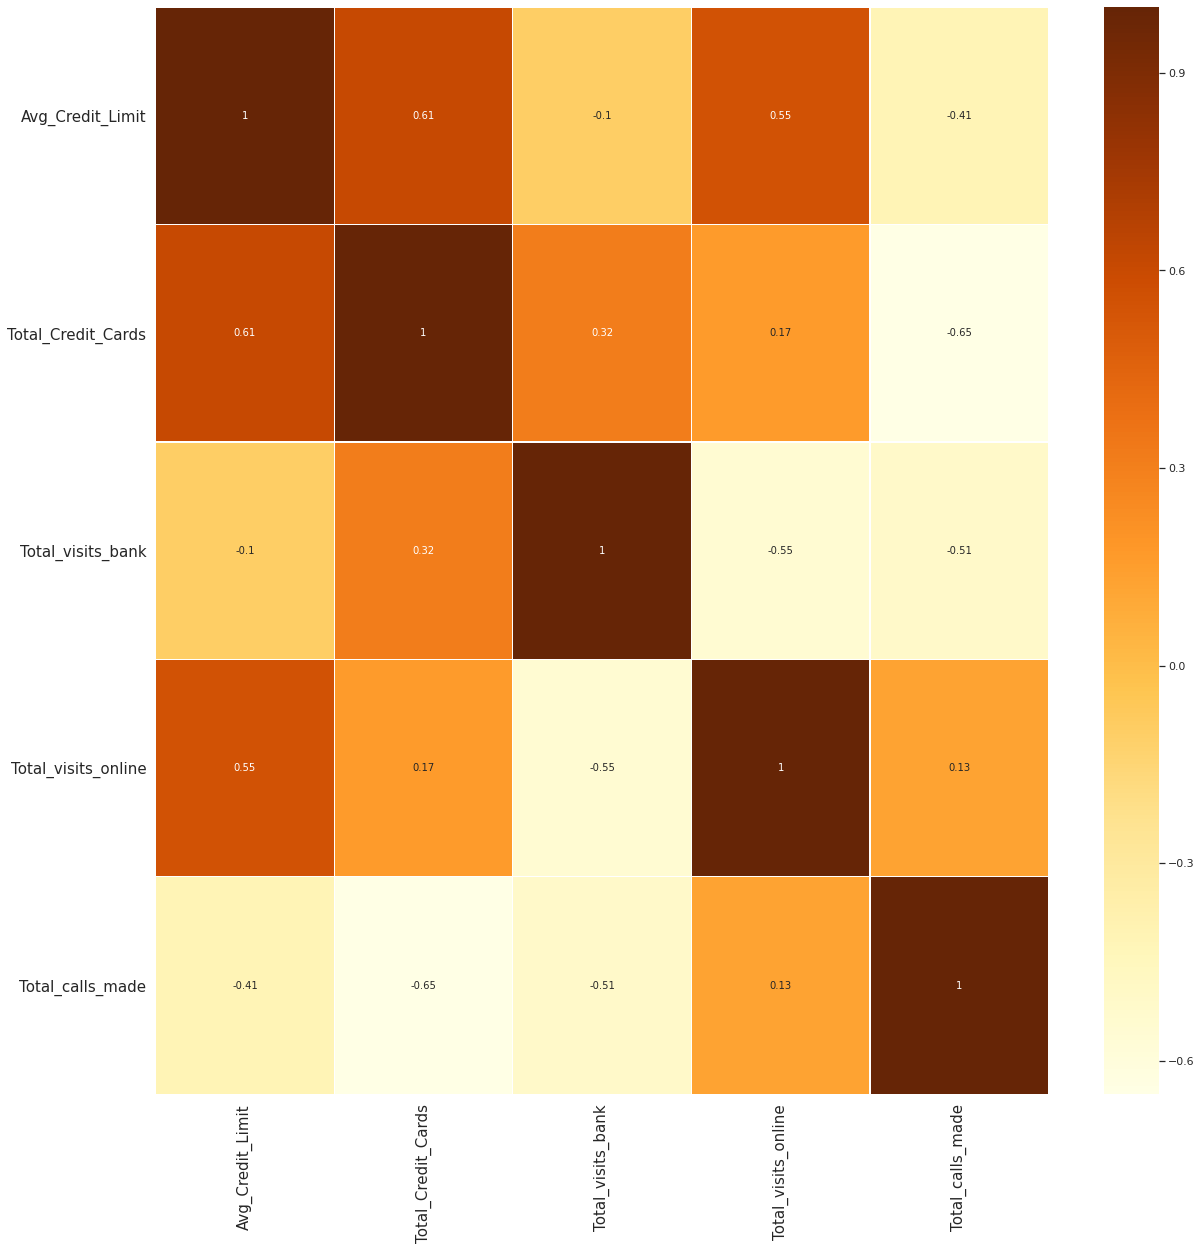

In [16]:
# Create Correlation Heat map for finding The most relevent feature
corr = compute_df.corr()
sns.heatmap(corr,annot=True,cmap='YlOrBr',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [17]:
compute_df.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            100000                   2                  1   
1             50000                   3                  0   
2             50000                   7                  1   
3             30000                   5                  1   
4            100000                   6                  0   

   Total_visits_online  Total_calls_made  
0                    1                 0  
1                   10                 9  
2                    3                 4  
3                    1                 4  
4                   12                 3

In [18]:
# Selected column Total_Credit_Cards,Total_visits_online,Total_calls_made for 3D analysis.we will use the same 
# graph for getting idea how cluster is form from data.

fig = px.scatter_3d(compute_df,x='Total_Credit_Cards',y='Total_visits_online',z='Total_calls_made')
fig.show()

### Here we can get idea about clusters

# Exploratory Data Quality Report

1) All data fields are numerical data (int 64) , there is no categorical variable column. so , there is no need to convert any data type.

2) Sl_no and Customer Key both columns are customer identifiers, it should not take into account for clustering. since both values are arbitory and technically no meaning, it may give irrelevant result.

3) By observing,  data is not mostly uniformly distributed. Avg_Credit_Limit and Total_visits_online both heavy positivly skewed while Total_calls_made is modertly positive skewed data.

4) By looking at box plot, concluding that there are some outliers in main two cloumns 1) Avg_Credit_Limit 2) Total_visits_online.

5) By Observing pair plot, there is obscure line for various clusters in every columns.

6) By looking at correlation matix, conclude that Total credit card and average credit limit has positive correlation, similarly Total credit card  and Total_visits_online has positive correlation.

7) Total credit card and Total_calls_made has negative correlation,similar way Total_calls_made and Total_visits_bank has negative correlation.

8) By observing data frequency graph (kde plot), there are 3-4 peaks for each distibution graph.Intutively, we can say there will be 3 or 4  clusters can be formed from this data.

9) data units are different for each columns(no,normalization must required before forming any cluster otherwise Avg_Credit_Limit column will dominate all other columns.

10) This dataset has no result(output, target) label. it is classic unsupervised learning problem to form cluster.

In [19]:
# check head for compute df
#compute_df.head()

# K-means clustering

In [20]:
# As mentioned in data analysis, need to scale data, for this zscore will be used
compute_df = compute_df.apply(zscore)
compute_df.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0          1.740187           -1.249225          -0.860451   
1          0.410293           -0.787585          -1.473731   
2          0.410293            1.058973          -0.860451   
3         -0.121665            0.135694          -0.860451   
4          1.740187            0.597334          -1.473731   

   Total_visits_online  Total_calls_made  
0            -0.547490         -1.251537  
1             2.520519          1.891859  
2             0.134290          0.145528  
3            -0.547490          0.145528  
4             3.202298         -0.203739

2 0.41842496663215445
3 0.5157182558881063
4 0.3556670619372605
5 0.2717470361089752
6 0.25588029066344975
7 0.2482713393360752
8 0.22381755097737194
9 0.22684995667674998
[0.41842496663215445, 0.5157182558881063, 0.3556670619372605, 0.2717470361089752, 0.25588029066344975, 0.2482713393360752, 0.22381755097737194, 0.22684995667674998]
range(2, 10)


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

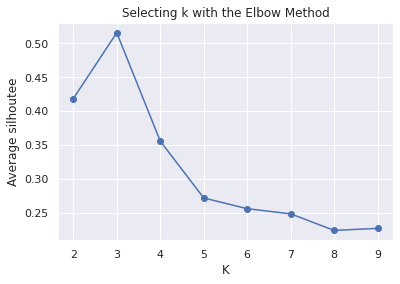

In [21]:
# First option for finding optimal number of clusters with avg silhouette score.

cluster_range = range(2,10)
sil = []

# looping 
for k in cluster_range:
    model=KMeans(n_clusters=k)
    model.fit(compute_df)
    prediction=model.predict(compute_df)
    sil_avg = silhouette_score(compute_df,prediction)
    sil.append(sil_avg)
    print(k,  sil_avg)

# plot elbow graph to find K
print(sil)
print(cluster_range)
plt.plot(cluster_range, sil, 'bo-')
plt.xlabel('K')
plt.ylabel('Average silhoutee')
plt.title('Selecting k with the Elbow Method')

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

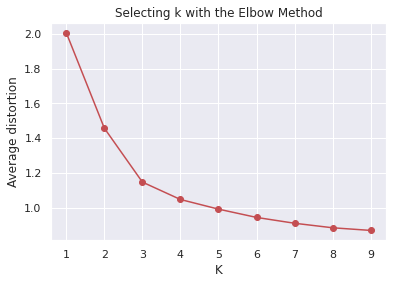

In [22]:
# Second Option, consider mean distrortion method for finding optimal number of clusters.

cluster_range = range(1,10)
meanDistortions=[]

# looping 
for k in cluster_range:
    model=KMeans(n_clusters=k)
    model.fit(compute_df)
    prediction=model.predict(compute_df)
    meanDistortions.append(sum(np.min(cdist(compute_df, model.cluster_centers_, 'euclidean'), axis=1)) / compute_df.shape[0])

# plot elbow graph to find K
plt.plot(cluster_range, meanDistortions, 'ro-')
plt.xlabel('K')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

### Both above graphs, elbow point seems at K=3 (highest silhouette differeence and max distortion at elbow point), However, after K=6 there will no significant distortion at all. we can try first with K=3 and also try with K=6 as well for some comparision

In [23]:
# define generic function for finding cluster lable based on K.
def get_labeled_cluster_dataframe(dataframe,compute_dataframe,clusters=3):
    kmeans = KMeans(n_clusters=clusters,random_state=42)
    kmeans.fit(compute_dataframe)
    prediction = kmeans.fit_predict(compute_dataframe)
    score = silhouette_score(compute_dataframe, prediction)
    print("silhouette score is :{} for K: {}".format(score,clusters))
    centroids = kmeans.cluster_centers_
    
    #Calculate the centroids for the columns to profile
    centroid_df = pd.DataFrame(centroids, columns = list(compute_dataframe))
    
    ## creating a new dataframe only for labels and converting it into categorical variable
    df_with_group = pd.DataFrame(kmeans.labels_ , columns = list(['group']))
    df_with_group['group'] = df_with_group['group'].astype('category')

    # Joining the label dataframe with the data frame.
    dataframe = dataframe.join(df_with_group)
    return dataframe

def get_score_silhouette_score(compute_dataframe, clusters=3):
    kmeans = KMeans(n_clusters=clusters,random_state=42)
    kmeans.fit(compute_dataframe)
    prediction = kmeans.fit_predict(compute_dataframe)
    score = silhouette_score(compute_dataframe, prediction)
    return score

In [24]:
# get labeled dataframe with K=3 
credit_df_with_3_cluster = get_labeled_cluster_dataframe(credit_df,compute_df,clusters=3)
credit_df_with_3_cluster_score = get_score_silhouette_score(compute_df,clusters=3)
print(credit_df_with_3_cluster_score)
# check cluster with group
credit_df_with_3_cluster.head()

silhouette score is :0.5157182558881063 for K: 3
0.5157182558881063


Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made group  
0                  1                    1                 0     0  
1                  0                   10                 9     2  
2                  1                    3                 4     0  
3                  1                    1                 4     0  
4                  0                   12                 3     1

In [25]:
# Check cluster stats
credit_df_with_3_cluster_gb = credit_df_with_3_cluster.groupby(['group'])
credit_df_with_3_cluster_gb.mean()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
group                                                                   
0      417.528497  54881.329016      33782.383420            5.515544   
1      611.280000  56708.760000     141040.000000            8.740000   
2      117.857143  55239.830357      12174.107143            2.410714   

       Total_visits_bank  Total_visits_online  Total_calls_made  
group                                                            
0               3.489637             0.981865          2.000000  
1               0.600000            10.900000          1.080000  
2               0.933036             3.553571          6.870536

In [26]:
# Count values of various group
credit_df_with_3_cluster['group'].value_counts()

0    386
2    224
1     50
Name: group, dtype: int64

### Box plot analysis for K-Means  K=3

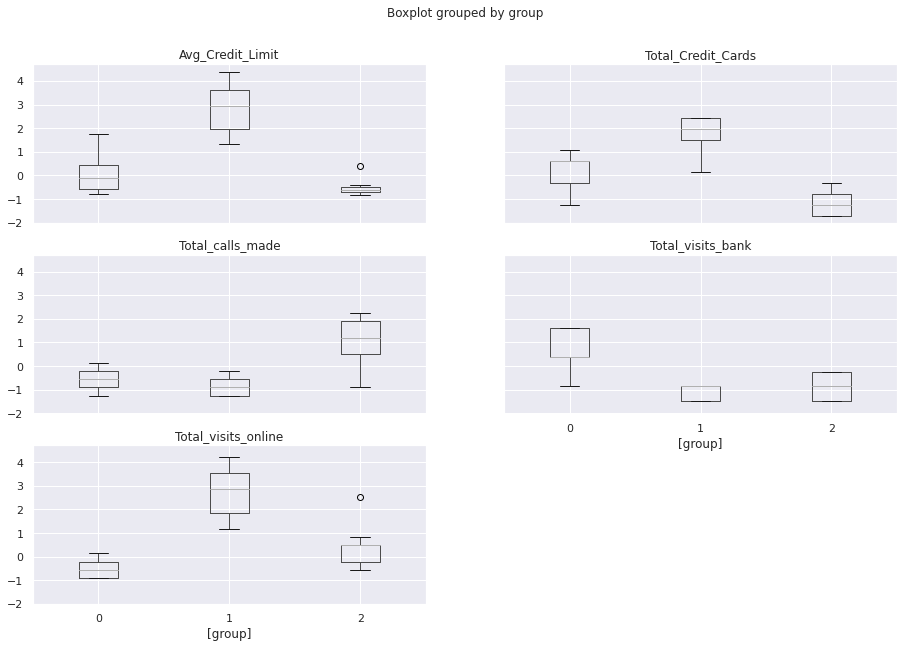

In [27]:
# get cluster lable
clusters = credit_df_with_3_cluster['group']

# drop unnecessary filed, here noted we will add cluster lables after standerdize df.
credit_df_with_3_cluster_box = credit_df_with_3_cluster.drop(['Sl_No','Customer Key','group'],axis=1)
credit_df_with_3_cluster_box = credit_df_with_3_cluster_box.apply(zscore)

# add back clustres
credit_df_with_3_cluster_box['group'] = clusters

# Box plot
credit_df_with_3_cluster_box.boxplot(by="group",figsize=(15,10));

### Above box plot, can clearly see three different clusters and each cluster is has distinct box. 

In [28]:
# Now check 3D plot with selected column to get idea, how cluster formed.
fig = px.scatter_3d(credit_df_with_3_cluster_box,x='Total_Credit_Cards',y='Total_visits_online',z='Total_calls_made',color='group')
fig.show()

### 3D scatter plot is clearly showing how 3 clusters arre formed and how distinct they are from each other. there is no overlaping with each other.

### Now, doing the same analysis for K-Means cluster for K=6

In [29]:
# get labeled dataframe with K=6
credit_df_with_6_cluster = get_labeled_cluster_dataframe(credit_df,compute_df,clusters=6)
credit_df_with_6_cluster_score = get_score_silhouette_score(compute_df,clusters=6)
print(credit_df_with_6_cluster_score)

silhouette score is :0.2555645280295032 for K: 6
0.2555645280295032


In [30]:
# Check cluster stats
credit_df_with_6_cluster_gb = credit_df_with_6_cluster.groupby(['group'])
credit_df_with_6_cluster_gb.mean()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
group                                                                   
0      405.182353  54740.388235      26970.588235            5.464706   
1      122.710280  56841.495327      12570.093458            2.420561   
2      484.342593  58163.268519      59805.555556            5.472222   
3      611.280000  56708.760000     141040.000000            8.740000   
4      370.148148  51821.240741      18481.481481            5.638889   
5      113.418803  53775.059829      11811.965812            2.401709   

       Total_visits_bank  Total_visits_online  Total_calls_made  
group                                                            
0               4.576471             1.041176          1.964706  
1               0.766355             3.719626          8.607477  
2               2.777778             0.907407          2.046296  
3               0.600000            10.900000          1.080000  
4               2.490741             0.962963          2.009259  
5               1.085470             3.401709          5.282051

In [31]:
# Count values of various group
credit_df_with_6_cluster['group'].value_counts()

0    170
5    117
4    108
2    108
1    107
3     50
Name: group, dtype: int64

### Box plot analysis for K-Means  K=6

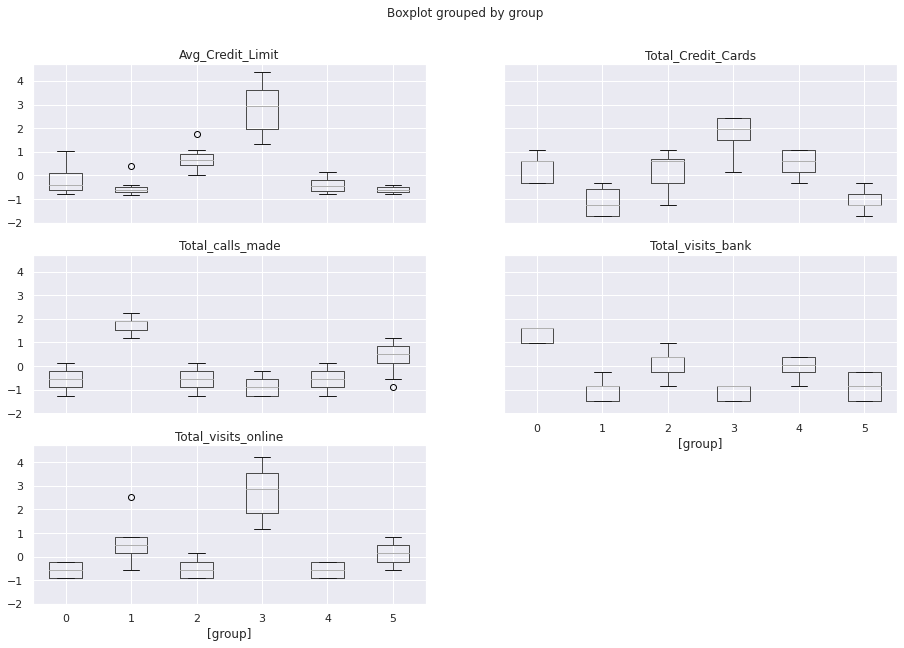

In [32]:
# get cluster lable
clusters = credit_df_with_6_cluster['group']

# drop unnecessary filed, here noted we will add cluster lables after standerdize df.
credit_df_with_6_cluster_box = credit_df_with_6_cluster.drop(['Sl_No','Customer Key','group'],axis=1)
credit_df_with_6_cluster_box = credit_df_with_6_cluster_box.apply(zscore)

# add back clustres
credit_df_with_6_cluster_box['group'] = clusters

# Box plot
credit_df_with_6_cluster_box.boxplot(by="group",figsize=(15,10));

### Above box plot, can clearly see three different clusters and each cluster is has distinct box.

In [33]:
# Now check 3D plot with selected column to get idea, how cluster formed.
fig = px.scatter_3d(credit_df_with_6_cluster_box,x='Total_Credit_Cards',y='Total_visits_online',z='Total_calls_made',color='group')
fig.show()

### By observing above 3D scatter plot with the same columns, at K=6 , there are some overlapped clusters that indicates K=6 is not a good choice compared to K=3.

In [34]:
# Finalize average silhouette score for K-Means cluster
silhouete_score_data = {"Clustering":["K-Means","K-Means"],"Cluster Size":["3","6"],"Average Silhouetee Score":[credit_df_with_3_cluster_score,credit_df_with_6_cluster_score]}
silhouete_score_df = pd.DataFrame(data=silhouete_score_data)
silhouete_score_df

Clustering Cluster Size  Average Silhouetee Score
0    K-Means            3                  0.515718
1    K-Means            6                  0.255565

### Ave. Silhouetee score is K=6 is significant lower than K=3.hence , K=3 is a optimum choice for forming cluster.

# Hierarchical clustering 

In [35]:
# drop unnecessary fields from df
interest_df = credit_df.drop(['Sl_No','Customer Key'], axis=1)

In [36]:
# standardize dataframe
compute_df_h = interest_df.apply(zscore)


In [37]:
# check head
compute_df_h.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0          1.740187           -1.249225          -0.860451   
1          0.410293           -0.787585          -1.473731   
2          0.410293            1.058973          -0.860451   
3         -0.121665            0.135694          -0.860451   
4          1.740187            0.597334          -1.473731   

   Total_visits_online  Total_calls_made  
0            -0.547490         -1.251537  
1             2.520519          1.891859  
2             0.134290          0.145528  
3            -0.547490          0.145528  
4             3.202298         -0.203739

In [38]:
# check shape
compute_df_h.shape

(660, 5)

### Executing hierarchical clsutering with linkages and find out the best linkage

In [39]:
# checking clustering with different linkage and select the best case
links = ["ward","single","average","median","complete"]
for each in links:
    Z = linkage(compute_df_h,method=each, metric='euclidean')
    cc,copen_dist = cophenet(Z,pdist(compute_df_h))
    print(each,cc)

ward 0.7415156284827492
single 0.7391220243806552
average 0.8977080867389372
median 0.8893799537016724
complete 0.8599730607972423


### By looking cophenet coeff, average linkage gives the best result, we can select average linkage for hierarchical  clustering , we can try another links as well

In [40]:
# Create linkage with average linkage
avg_linkage = linkage(compute_df_h, "average", metric='euclidean')

In [41]:
# check linkage matrix
avg_linkage[:]

array([[ 464.        ,  497.        ,    0.        ,    2.        ],
       [ 250.        ,  361.        ,    0.        ,    2.        ],
       [ 252.        ,  324.        ,    0.        ,    2.        ],
       ...,
       [   0.        , 1309.        ,    3.11135778,  387.        ],
       [1315.        , 1316.        ,    3.25253923,  610.        ],
       [1314.        , 1317.        ,    5.45418035,  660.        ]])

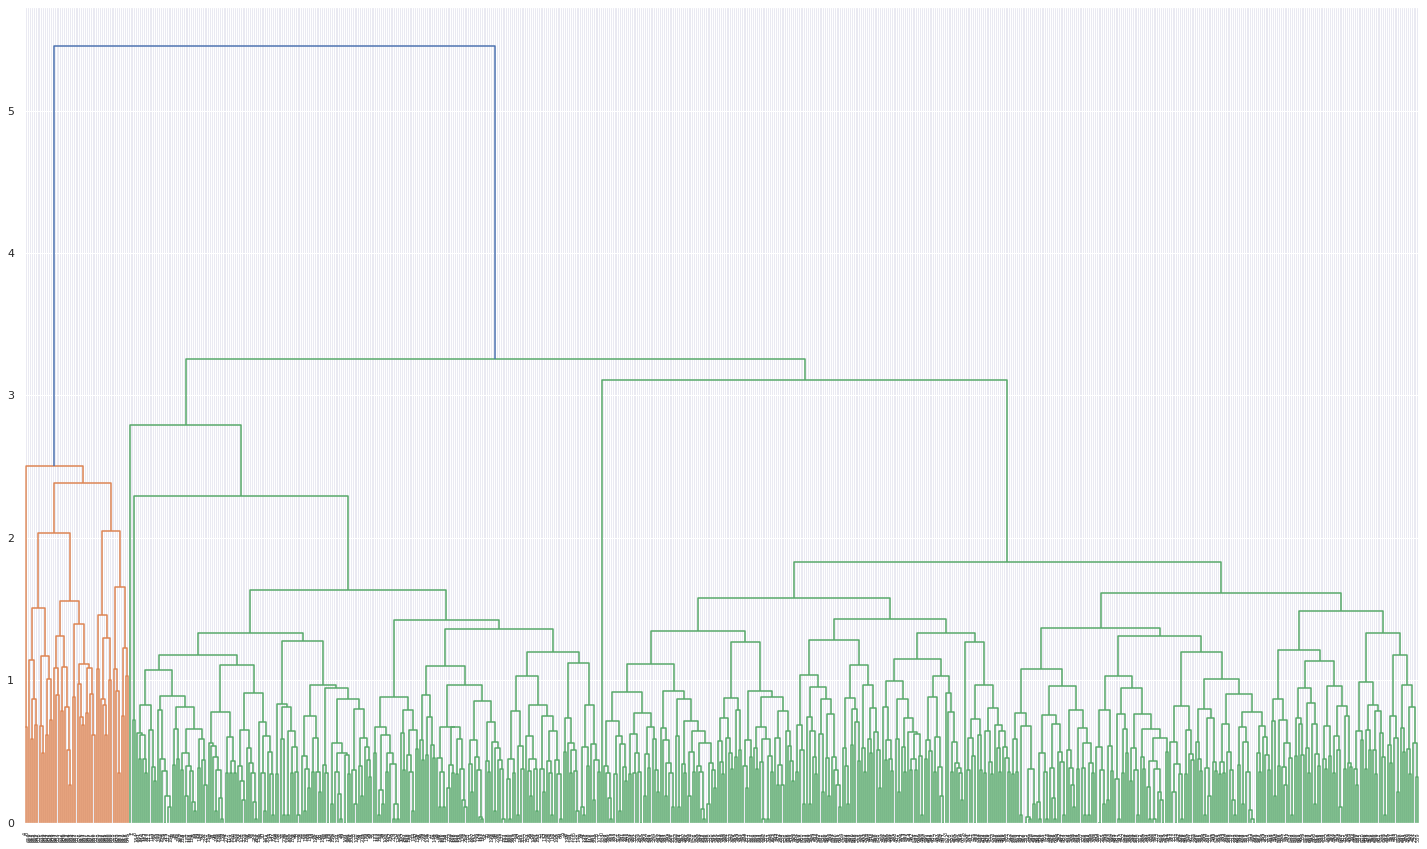

In [42]:
# now plot dendogram by using created linkage
plt.figure(figsize=(25, 15))
dendrogram(avg_linkage)
plt.show()

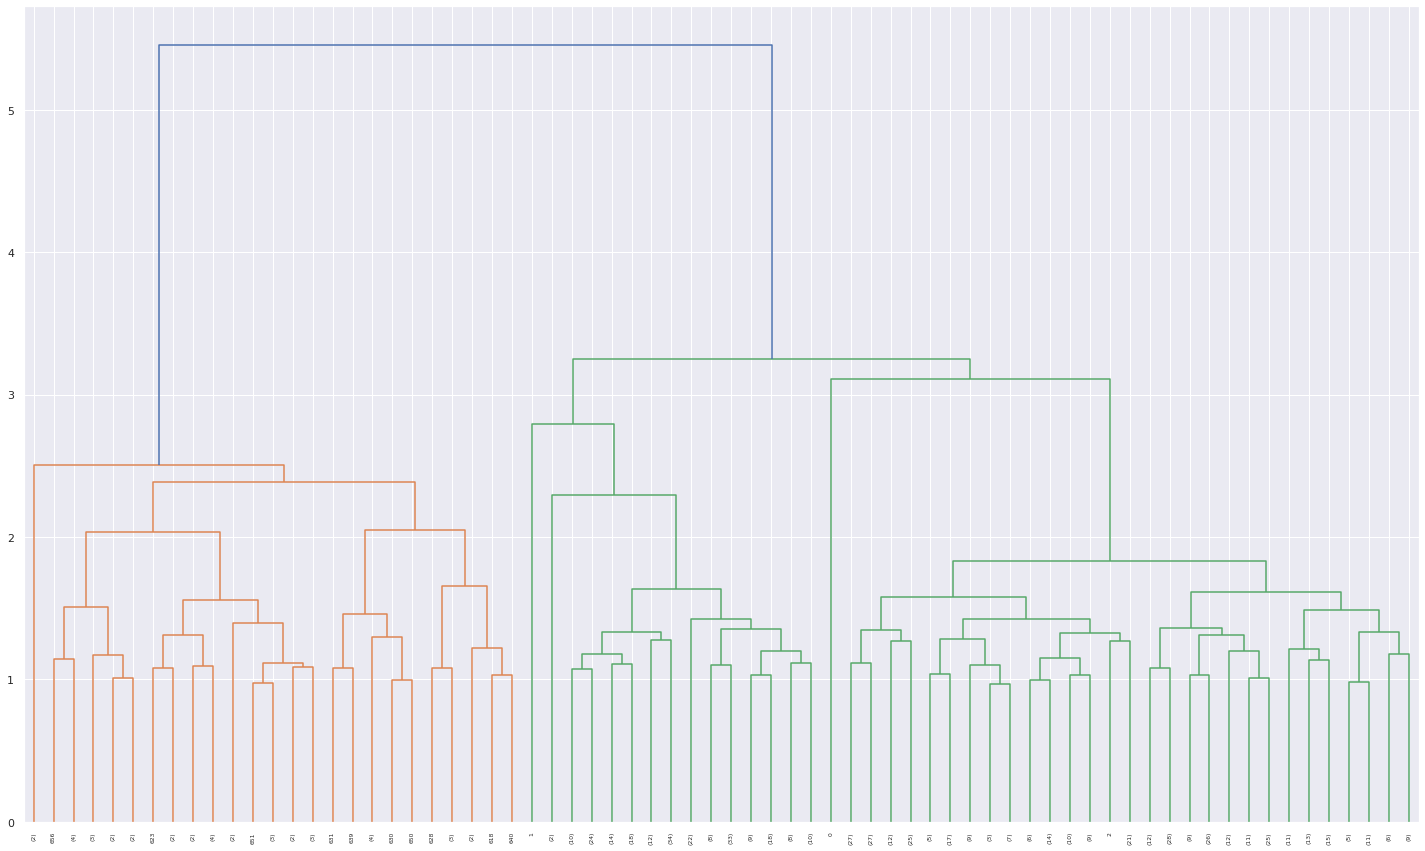

In [43]:
# Plot dendogram with brief and truncate mode with last 10% ~70 datapoints.
plt.figure(figsize=(25, 15))
dendrogram(avg_linkage,truncate_mode='lastp',p=70)
plt.show()

### Dendogram shows  it will form 4 clusters at max_d=3,  if we want to form 3 clusters then we should select max_d between 3 to 3.5, Lets select max_d = 3.2.

In [44]:
# max_d value for forming clusters
max_d = 3.2

In [45]:
# get clusters
clusters = fcluster(avg_linkage, max_d, criterion='distance')

In [46]:
# get distincts clusters
set(clusters)

{1, 2, 3}

In [47]:
# label cluster to df
original_df_hierarchical = credit_df.copy()
compute_df_h['cluster_avg'] = clusters
original_df_hierarchical['cluster_avg'] = clusters
compute_df_h.head(100)

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0           1.740187           -1.249225          -0.860451   
1           0.410293           -0.787585          -1.473731   
2           0.410293            1.058973          -0.860451   
3          -0.121665            0.135694          -0.860451   
4           1.740187            0.597334          -1.473731   
..               ...                 ...                ...   
95         -0.786612           -1.710864          -0.247170   
96         -0.440840           -0.787585          -0.247170   
97         -0.520633           -1.249225          -1.473731   
98         -0.573829           -1.710864          -0.860451   
99         -0.786612           -1.249225          -0.860451   

    Total_visits_online  Total_calls_made  cluster_avg  
0             -0.547490         -1.251537            3  
1              2.520519          1.891859            2  
2              0.134290          0.145528            3  
3             -0.547490          0.145528            3  
4              3.202298         -0.203739            1  
..                  ...               ...          ...  
95             0.816070          1.193326            2  
96             0.134290          0.844060            2  
97             0.816070          0.145528            2  
98             0.475180          1.891859            2  
99             0.475180          0.844060            2  

[100 rows x 6 columns]

In [48]:
compute_df_h.groupby(['cluster_avg']).size()

cluster_avg
1     50
2    223
3    387
dtype: int64

In [49]:
# Compute  Silhoutte Score for hierarchical cluster for 3 clusters.
silhouette_score_3_hierarchical = silhouette_score(compute_df_h,clusters)
silhouette_score_3_hierarchical

0.5413025796835772

In [50]:
# Now check cluster stats
clustered_df = compute_df_h.groupby(['cluster_avg'])
clustered_df.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
cluster_avg                                                            
1                    2.831764            1.862226          -1.105763   
2                   -0.595179           -1.062913          -0.904453   
3                   -0.022902            0.371882           0.664034   

             Total_visits_online  Total_calls_made  
cluster_avg                                         
1                       2.827319         -0.874330  
2                       0.325372          1.152605  
3                      -0.552775         -0.551200

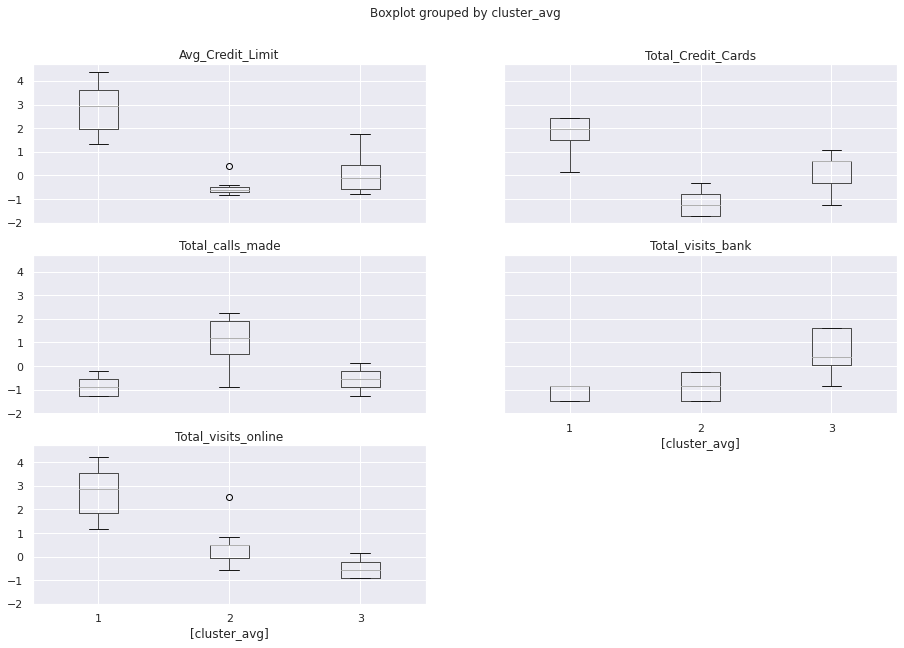

In [51]:
compute_df_h.boxplot(by='cluster_avg',figsize=(15,10));

In [52]:
# Now check 3D plot with selected column to get idea, how cluster formed.
fig = px.scatter_3d(compute_df_h, x='Total_Credit_Cards',y='Total_visits_online',z='Total_calls_made',color='cluster_avg')
fig.show()

### now get 6 clusters and for this max_d should be select between 2.0 to 2.5

In [53]:
# Now for cluster 
max_d = 2.5

# get clusters
clusters_for_6 = fcluster(avg_linkage, max_d, criterion='distance')

# get distincts clusters
set(clusters_for_6)

{1, 2, 3, 4, 5, 6}

In [54]:
# label cluster to df
compute_df_h_6 = interest_df.apply(zscore).copy()
compute_df_h_6['cluster_avg'] = clusters_for_6


In [55]:
compute_df_h_6.groupby(['cluster_avg']).size()

cluster_avg
1      2
2     48
3    222
4      1
5    386
6      1
dtype: int64

In [56]:
# Compute  Silhoutte Score for hierarchical cluster for 6 clusters.
silhouette_score_6_hierarchical = silhouette_score(compute_df_h_6,clusters_for_6)
silhouette_score_6_hierarchical

0.47334200328719855

In [57]:
# Now check cluster stats
clustered_df = compute_df_h_6.groupby(['cluster_avg'])
clustered_df.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
cluster_avg                                                            
1                    1.740187            0.366514          -1.473731   
2                    2.877246            1.924548          -1.090431   
3                   -0.599708           -1.064153          -0.901888   
4                    0.410293           -0.787585          -1.473731   
5                   -0.027470            0.376082           0.667983   
6                    1.740187           -1.249225          -0.860451   

             Total_visits_online  Total_calls_made  
cluster_avg                                         
1                       3.031853         -0.378372  
2                       2.818797         -0.894995  
3                       0.315484          1.149275  
4                       2.520519          1.891859  
5                      -0.552789         -0.549386  
6                      -0.547490         -1.251537

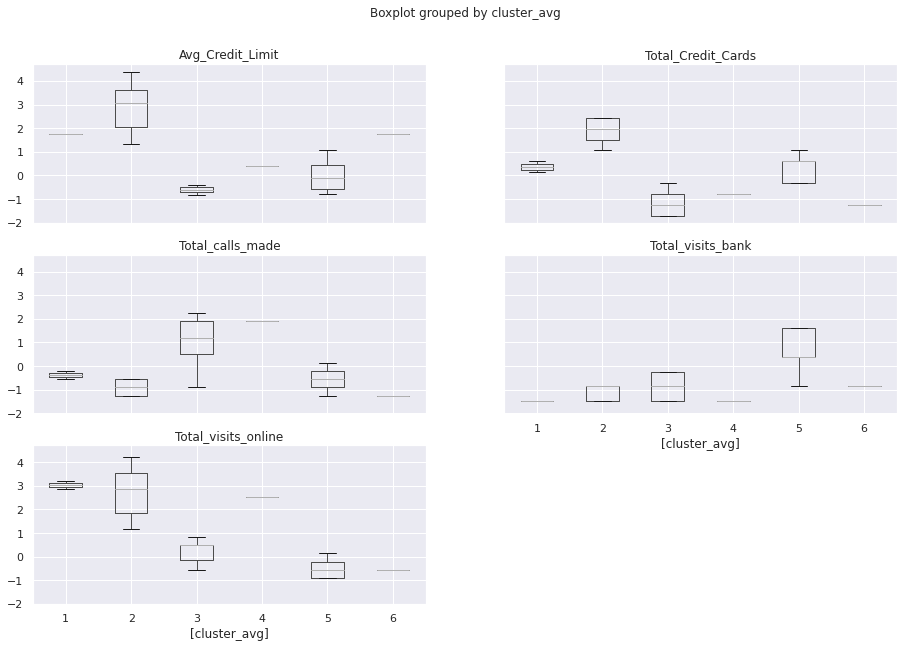

In [58]:
compute_df_h_6.boxplot(by='cluster_avg',figsize=(15,10));

In [59]:
# Now check 3D plot with selected column to get idea, how cluster formed.
fig = px.scatter_3d(compute_df_h_6, x='Total_Credit_Cards',y='Total_visits_online',z='Total_calls_made',color='cluster_avg')
fig.show()

### check with the ward linkage

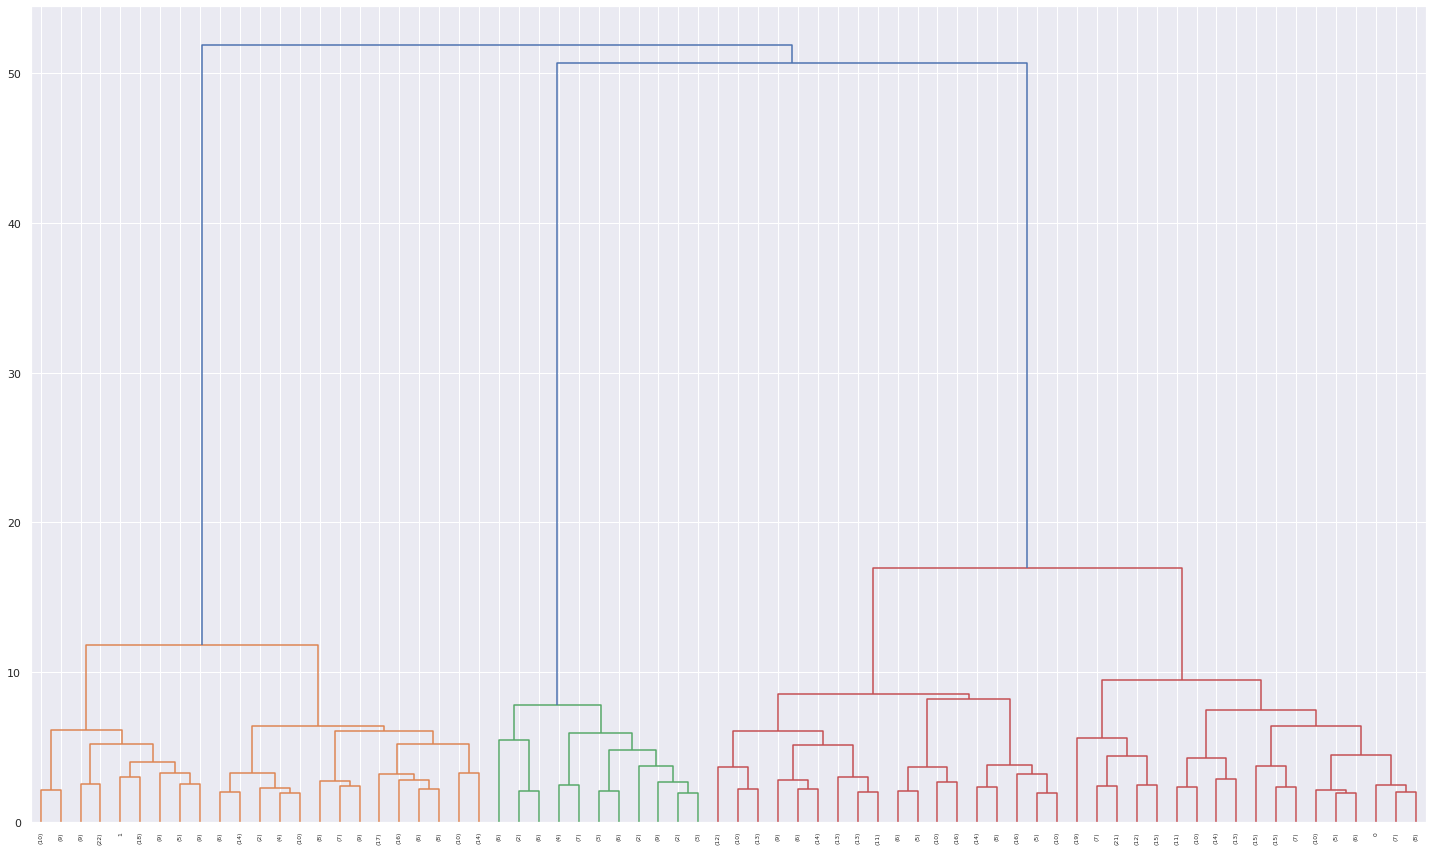

In [60]:
# Create linkage with ward linkage
ward_linkage = linkage(compute_df_h, "ward", metric='euclidean')

# Plot dendogram with brief and truncate mode with last 10% ~70 datapoints.
plt.figure(figsize=(25, 15))
dendrogram(ward_linkage,truncate_mode='lastp',p=70)
plt.show()

In [61]:
# form 3 cluster from ward linkage 
max_d = 30
ward_clusters = fcluster(ward_linkage, max_d, criterion='distance')

# label cluster to df
compute_df_ward_3 = interest_df.apply(zscore).copy()
compute_df_ward_3['cluster_ward'] = ward_clusters


# Compute  Silhoutte Score for hierarchical cluster for 3 clusters.
silhouette_score_3_hierarchical_ward = silhouette_score(compute_df_ward_3,ward_clusters)
silhouette_score_3_hierarchical_ward

0.5909904735964009

In [62]:
# Now check cluster stats
compute_df_ward_3_gb = compute_df_ward_3.groupby(['cluster_ward'])
compute_df_ward_3_gb.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
cluster_ward                                                            
1                    -0.595179           -1.062913          -0.904453   
2                     2.831764            1.862226          -1.105763   
3                    -0.022902            0.371882           0.664034   

              Total_visits_online  Total_calls_made  
cluster_ward                                         
1                        0.325372          1.152605  
2                        2.827319         -0.874330  
3                       -0.552775         -0.551200

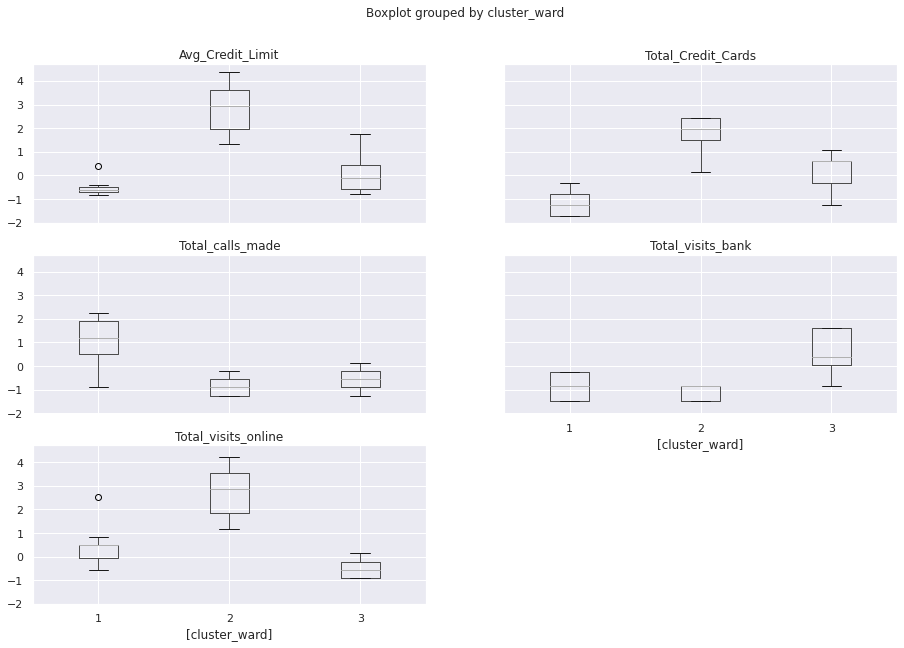

In [63]:
compute_df_ward_3.boxplot(by='cluster_ward',figsize=(15,10));

### check with the single linkage

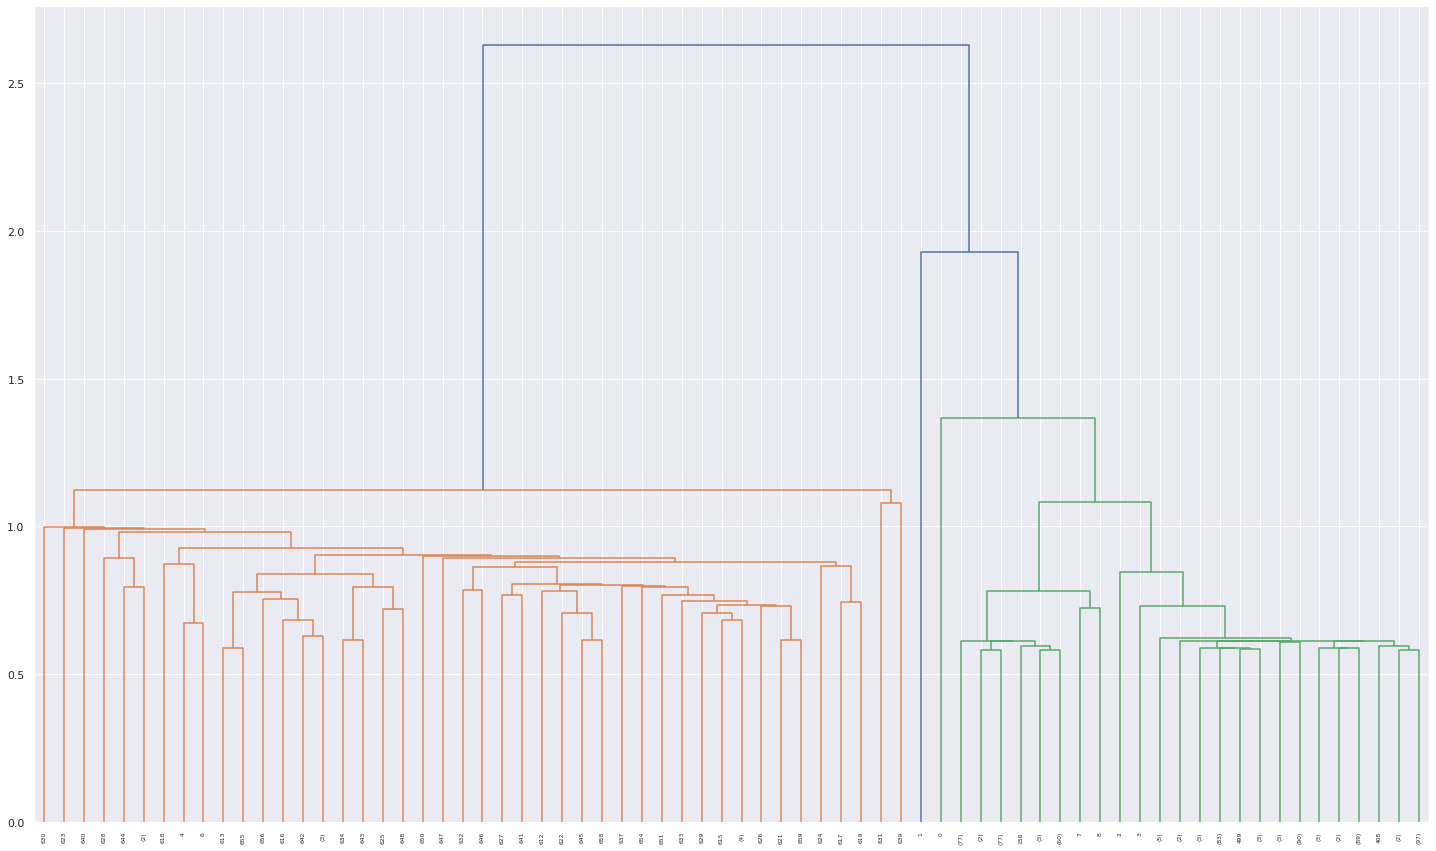

In [64]:
# Create linkage with single linkage
single_linkage = linkage(compute_df_h, "single", metric='euclidean')

# Plot dendogram with brief and truncate mode with last 10% ~70 datapoints.
plt.figure(figsize=(25, 15))
dendrogram(single_linkage,truncate_mode='lastp',p=70)
plt.show()

### by looking at dendogram, single linkage is trying to put data in to a cluster, it seems not good 

In [65]:
# form 3 cluster from single linkage 
max_d = 1.5
single_cluster = fcluster(single_linkage, max_d, criterion='distance')

# label cluster to df
compute_df_single_3 = interest_df.apply(zscore).copy()
compute_df_single_3['cluster_single'] = single_cluster


# Compute  Silhoutte Score for hierarchical cluster for 3 clusters.
silhouette_score_3_hierarchical_single = silhouette_score(compute_df_single_3,single_cluster)
silhouette_score_3_hierarchical_single

0.40082978699701527

In [66]:
compute_df_single_3.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0          1.740187           -1.249225          -0.860451   
1          0.410293           -0.787585          -1.473731   
2          0.410293            1.058973          -0.860451   
3         -0.121665            0.135694          -0.860451   
4          1.740187            0.597334          -1.473731   

   Total_visits_online  Total_calls_made  cluster_single  
0            -0.547490         -1.251537               2  
1             2.520519          1.891859               3  
2             0.134290          0.145528               2  
3            -0.547490          0.145528               2  
4             3.202298         -0.203739               1

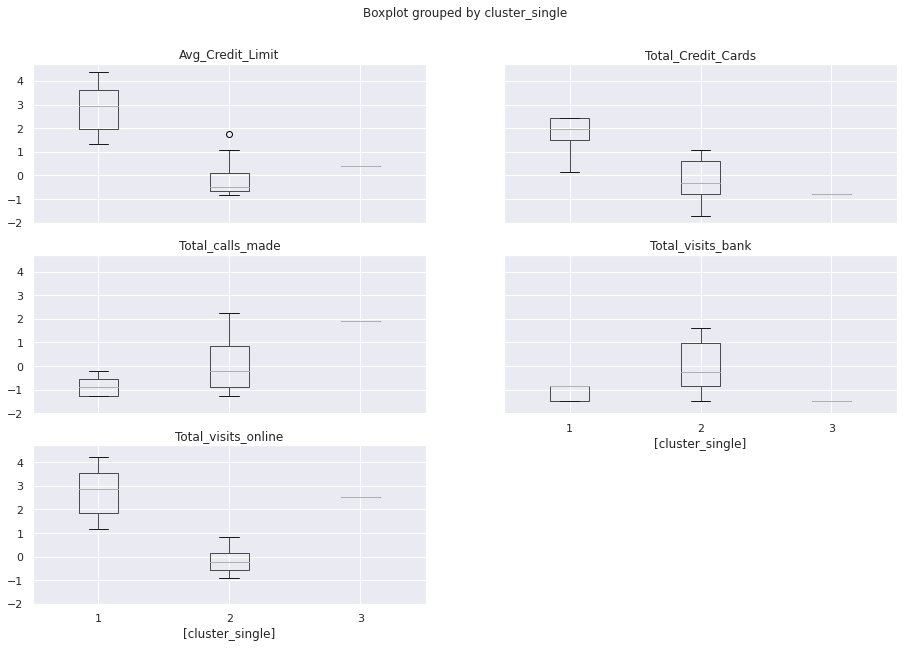

In [67]:
compute_df_single_3.boxplot(by='cluster_single',figsize=(15,10));

### As we expected from dendogram, single linkage silhouette score is not good.

### check with the complete linkage

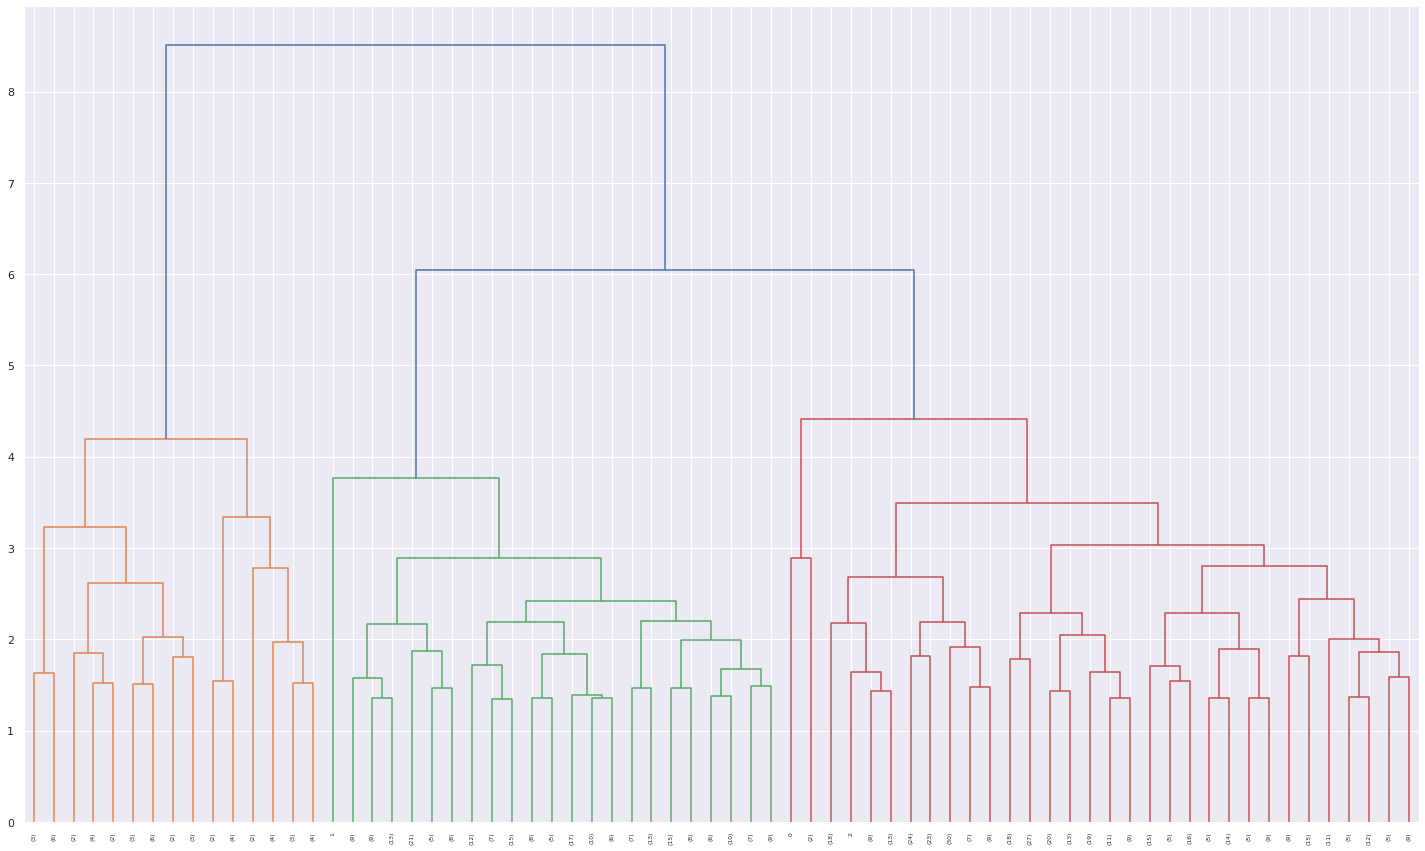

In [68]:
# Create linkage with complete linkage
complete_linkage = linkage(compute_df_h, "complete", metric='euclidean')

# Plot dendogram with brief and truncate mode with last 10% ~70 datapoints.
plt.figure(figsize=(25, 15))
dendrogram(complete_linkage,truncate_mode='lastp',p=70)
plt.show()

In [69]:
# form 3 cluster from complete linkage 
max_d = 5
complete_clusters = fcluster(complete_linkage, max_d, criterion='distance')

# label cluster to df
compute_df_complete_3 = interest_df.apply(zscore).copy()
compute_df_complete_3['cluster_complete'] = complete_clusters


# Compute  Silhoutte Score for hierarchical cluster for 3 clusters.
silhouette_score_3_hierarchical_complete = silhouette_score(compute_df_complete_3,complete_clusters)
silhouette_score_3_hierarchical_complete

0.540039358199808

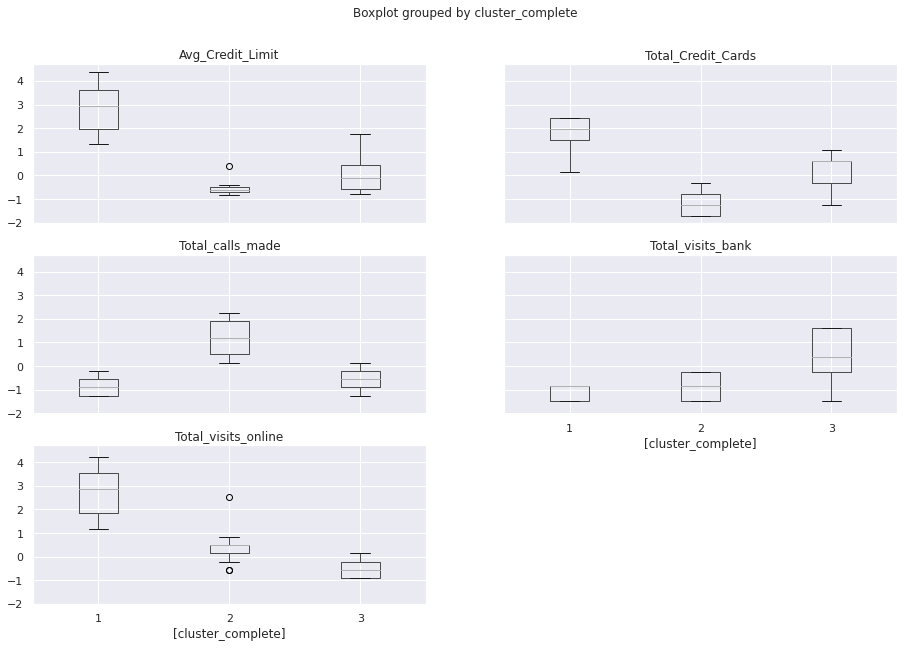

In [70]:
compute_df_complete_3.boxplot(by='cluster_complete',figsize=(15,10));

## Conclusion: Eventhough Average linkage has highest cophenetic coeff. ward linkage has the highest silhouette score. 

# Silhouette Score Summary

In [71]:
# Finalize average silhouette score for K-Means cluster
silhouete_score_data = {"Clustering":["k-means","k-means","hierarchical","hierarchical","hierarchical","hierarchical","hierarchical"],"Cluster Size":["3","6","3","6","3","3","3"],"Average Silhouetee Score":[credit_df_with_3_cluster_score,credit_df_with_6_cluster_score,silhouette_score_3_hierarchical,silhouette_score_6_hierarchical,silhouette_score_3_hierarchical_single,silhouette_score_3_hierarchical_ward,silhouette_score_3_hierarchical_complete],"Linkage":["-","-","average","average","single","ward","complete"]}
silhouete_score_df_final = pd.DataFrame(data=silhouete_score_data)
silhouete_score_df_final

Clustering Cluster Size  Average Silhouetee Score   Linkage
0       k-means            3                  0.515718         -
1       k-means            6                  0.255565         -
2  hierarchical            3                  0.541303   average
3  hierarchical            6                  0.473342   average
4  hierarchical            3                  0.400830    single
5  hierarchical            3                  0.590990      ward
6  hierarchical            3                  0.540039  complete

# Compare K-Means clusters and Hierarchical clusters

1) By looking at Silhouette Score and cluster formed, Both clusters are giving decent score at K=3 clusters so we can conclude that data has optimal 3 clusters.

2) k-means has highest silhouete score at K=3,We can see clear elbow at k=3 at mean distortion graph.

3) Hierarchical clusters are mostly formed based on maximum distance, this distnace is chosen by data anaylsit so often cluster formation is dependent on this numeric value. 

4) As we increase cluster size, ( 3 to 6), K-means clustering performance impacted heavly (approximate 60% down) while hierarchical clustering performance is not as much impacting (~ 8-10%) based on silhouete score.

5) at k=3, both clustering techniques group almost identically. however, this is not true for higher number of k ( k>3).


# Cluster Analysis and Answer to Key Quetions

By observing  silhouette scores and scatters plots, It is clear that this data has minimum 3 disticts clusters by both methods.Larger number of k ( k >3 ) can be slected, however, it performaace getting poor based on silhouette scores.


In [72]:
# Here are cluster statistic formed by both cluster methods

### Cluster formed by K-Means clusering at K=3

In [73]:
credit_df_with_3_cluster_gb = credit_df_with_3_cluster.groupby(['group'])
credit_df_with_3_cluster_gb.mean()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
group                                                                   
0      417.528497  54881.329016      33782.383420            5.515544   
1      611.280000  56708.760000     141040.000000            8.740000   
2      117.857143  55239.830357      12174.107143            2.410714   

       Total_visits_bank  Total_visits_online  Total_calls_made  
group                                                            
0               3.489637             0.981865          2.000000  
1               0.600000            10.900000          1.080000  
2               0.933036             3.553571          6.870536

In [74]:
credit_df_with_3_cluster['group'].value_counts()

0    386
2    224
1     50
Name: group, dtype: int64

### Cluster formed by Hierarchical clustering at average linkage (max_d = 3.2) with 3 clusters

In [75]:
#original_df['cluster_avg'] = clusters
credit_df_with_3_cluster_gb_h = original_df_hierarchical.groupby(['cluster_avg'])
credit_df_with_3_cluster_gb_h.mean()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
cluster_avg                                                                   
1            611.280000  56708.760000     141040.000000            8.740000   
2            116.977578  55163.973094      12197.309417            2.403587   
3            417.260982  54925.966408      33713.178295            5.511628   

             Total_visits_bank  Total_visits_online  Total_calls_made  
cluster_avg                                                            
1                     0.600000            10.900000          1.080000  
2                     0.928251             3.560538          6.883408  
3                     3.485788             0.984496          2.005168

In [76]:
original_df_hierarchical['cluster_avg'].value_counts()

3    387
2    223
1     50
Name: cluster_avg, dtype: int64

## Answer to Key Questions:

### How many different segments of customers are there?

### Observing clusters formed by both methods, There are 3 distinct customer groups.


1) Segment 1: High Credit limit group(mean with >140 K) with More credits cards ( mean with > 5).

2) Segment 2: Medium Credit limit group (33 K < mean < 140 K) with credit cards ( 2 < mean < 5).

3) Segment 3: Low Credit limit group ( mean < 33K) with average 2 credit cards.



### How are these segments different from each other? 

1)  Segment 1 (High Credit limit): This group is has potential for spending money and high buying power. This group prefers online visits over the bank visit. also this group is making less phone call than other two groups.This group is comparitivly uniform and by looking at box plot, there is no outlier present in this group.  50 customers are in this category.which is the lowest number of customers.

2) Segment 2 ( Medium Credit limit): This group has medium buying power.This group prefers bank visit over the online visit.also this group is making moderate call then other two groups. By looking at box plot, In this group there is no outliers.387 cutomers are in this category which is the highest number of customers.

3) Segment 3 ( Low credit limit): This group has low buying power and low number of credit card.this group prefers moderetly visit online and often visit bank as well. This group pefers phone calls and making highest phone call than other two groups. By looking at box plot, In this group there are some outliers in this group.223 cutomers are in this category.


### What are your recommendations to the bank on how to better market to and service these customers?

Obeserving above,Some recommendations are listed below

1) Recommendation 1: Improve online site functionalities and user experience.

    Since High buying power customer ( segment 1) are prefer online visits, bank should add more functionalities to web site. so this cutomers can access bank with ease and provide more revenue to the bank.Bank also should add more security to website as well since any fraud may result into loosing high spending customer. Bank should revise sonline site and allocate budget for improvement or add new features.

2) Recommendation 2: Bank can reduce  budget on phone service.

    Most of the customers (~ 67% ) with high to moderate buying power are not interested to making phone calls either they prefers bank visit or online visit. In this condition, bank can focus more on other requirements and reduce budget on phone service.
    
3) Recommendation 3: Improve bank onsite facility.

    group with the most number of customers ( segment 2) is prefer bank visit over any other communication medium. so satisfy this group bank should improve their onsite facility.
    


    